
download http://188.138.127.15:81/Datasets/CampusSeq1.zip

unzip /media/tanke/Data/datasets/pak/epfl_campus/CampusSeq1.zip
unzip /media/tanke/Data/datasets/pak/epfl_campus/CampusSeq1.zip -> /media/tanke/Data/datasets/pak/epfl_campus


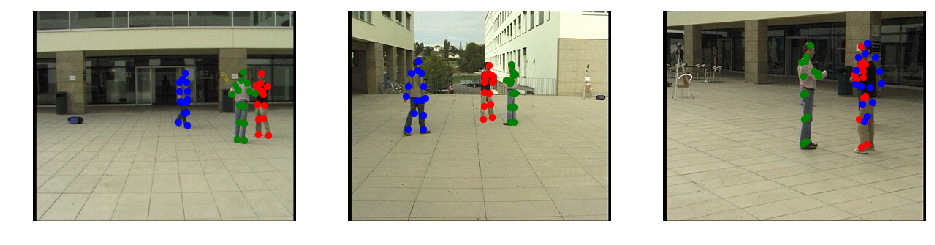

In [1]:
# Evaluation frames: [350 - 470] and [650 - 750].

%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

#[351 352 353 354 355 356 357 358 669 670 671 672 680 690 691 692 693]
#FRAME = 716
FRAME = 738
#FRAME = 353
X, Y, Calib = epfl_campus.get(root, FRAME)

fig = plt.figure(figsize=(16,16))

COLORS = ['red', 'green', 'blue', 'yellow']

for cid in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, cid+1)
    cam = Calib[cid]
    im = X[cid]
    ax.imshow(im)
    ax.axis('off')
    
    for pid, person in enumerate(Y):
        pts3d = person
        if pts3d is None:
            continue
        
        pts2d = cam.projectPoints(pts3d)
        for u, v in pts2d:
            ax.scatter(u, v, color=COLORS[pid])

plt.show()

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


step 1: elapsed 0.1442258358001709
step 2: elapsed 0.007004261016845703
step 3: elapsed 0.05706453323364258
step 4: elapsed 0.1835484504699707
-------------------------------------------
Handle transitivity:
	Intra:		 29
	Intra(choice):	 12
	Inter:		 530
	Inter(choice):	 316
-------------------------------------------
	Time =  238  ms
	result: 0

	Total cost: 650.7723790638365

# valid points:		 216
# invalid points:	 22
step 5: elapsed 0.2484450340270996
(smart candidate selection) [
	Time =  12  ms
	result: 0

	Total cost: 10.927596192781088
] (smart candidate selection)
step 6: elapsed 0.040715694427490234

# detections 3


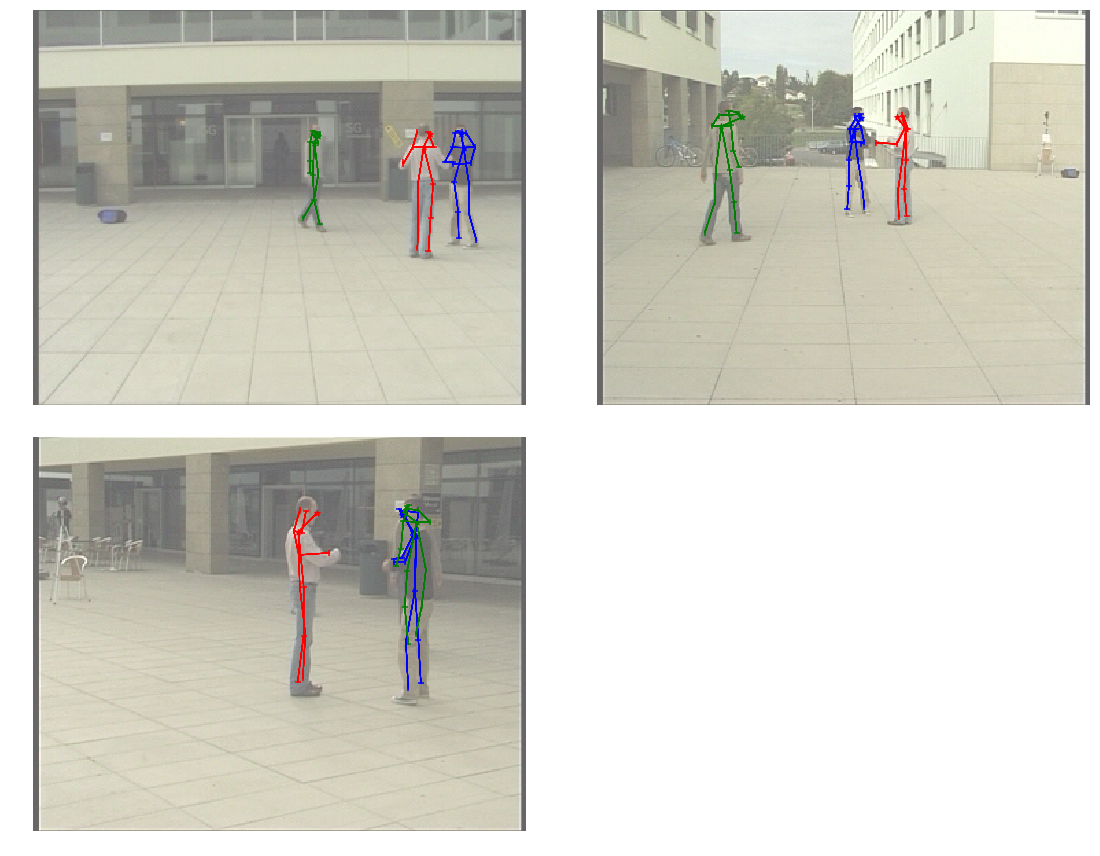

In [2]:
# ==================================
from mvpose import pose
from mvpose.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human

Im, Y, Calib = epfl_campus.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('campus', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)

#param = get_settings(scale_to_mm=1000)
param = get_settings(
    scale_to_mm=1000,
    ms_radius=50,
    ms_between_distance=50
)


Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['blue', 'red', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.tight_layout()
plt.show()

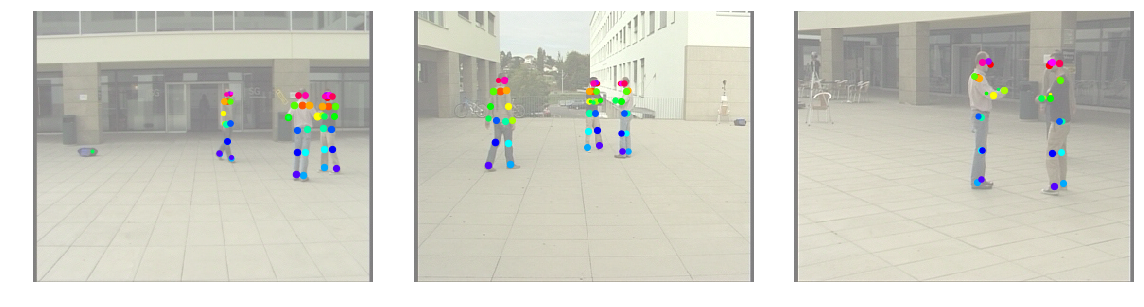

In [3]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.tight_layout()
plt.show()

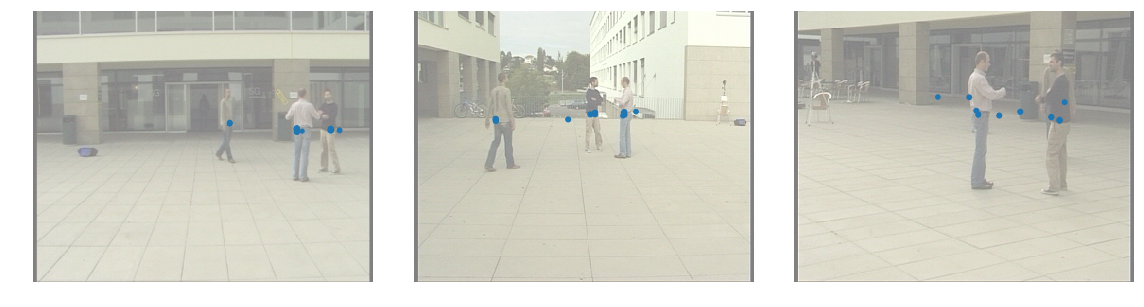

In [4]:
import mvpose.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
 
plt.tight_layout()
plt.show()

In [5]:
gc = Debug.graphcut
iota_sums = gc.iota_sums
lambda_sums = gc.lambda_sums

ALL = []

for lid, sums in enumerate(lambda_sums):
    if len(sums) == 0:
        continue
    ALL += sums
    

print('avg:', np.mean(ALL))
print('std:', np.std(ALL))
print('min:', np.min(ALL))
print('max:', np.max(ALL))

avg: 1.9829473112636211
std: 1.064166575258708
min: -0.37207962249827686
max: 4.87020313120984
